In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

import scbeta_scrnaseq.figure_vis as fv

from sklearn.neighbors import RadiusNeighborsRegressor, KernelDensity


from scbeta_scrnaseq.figure_vis import core_colors
fv.setup_matplotlib_params()

mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


In [2]:
importlib.reload(fv)

<module 'scbeta_scrnaseq.figure_vis' from '/Users/averes/Projects/Melton/Papers/Mapping_SCbeta/2019_02_04_final_version/code/scbeta_scrnaseq/figure_vis.py'>

In [3]:
import glob
pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [6]:
ds = loompy.connect('../02_Stage_6/data/complete_processing/stage6.processed.loom')
# ds.vals = sp.sparse.csr_matrix(ds.layers[""][:, :])


In [7]:
for d in range(6):
    print(f'Stage 6, week {d}: {Counter(ds.ca.CellWeek)[d]} cells')

Stage 6, week 0: 7064 cells
Stage 6, week 1: 8479 cells
Stage 6, week 2: 6646 cells
Stage 6, week 3: 5064 cells
Stage 6, week 4: 4856 cells
Stage 6, week 5: 6385 cells


In [8]:

scb_ds = loompy.connect('../02_Stage_6/data/pseudotime/stage6.scbeta_pseudotime.loom')
scb_ds.vals = sp.sparse.csr_matrix(scb_ds.layers[""][:, :])

In [9]:
scb_ds.shape

(16039, 10034)

In [10]:
label_order = ['scbeta', 'ph', 'ec', 'sst',  'neurog3',  'exo', 'other', 'repl']
ratio_order = ['scbeta', 'ph', 'ec', 'sst', 'neurog3',  'exo', 'other', 'repl']

## Main tSNE + ratio bars

In [17]:
# _tsne_proj = utils.load_df('/Volumes/beta_cell/Users/adrianveres/data/Computation/Stage6/2018-12-10/tsne/tsne_proj.2018_12_10_r5.n_hvgs2000.npcs25.p200.s3452921.i10000.df.npz')
# _tsne_proj[0] *= -1
# ds.ca['TSNE'] = _tsne_proj.loc[ds.ca.CellID].fillna(0.0).values
# set(ds.ca.CellID).difference(set(_tsne_proj.index)), set(set(_tsne_proj.index) ).difference(ds.ca.CellID)

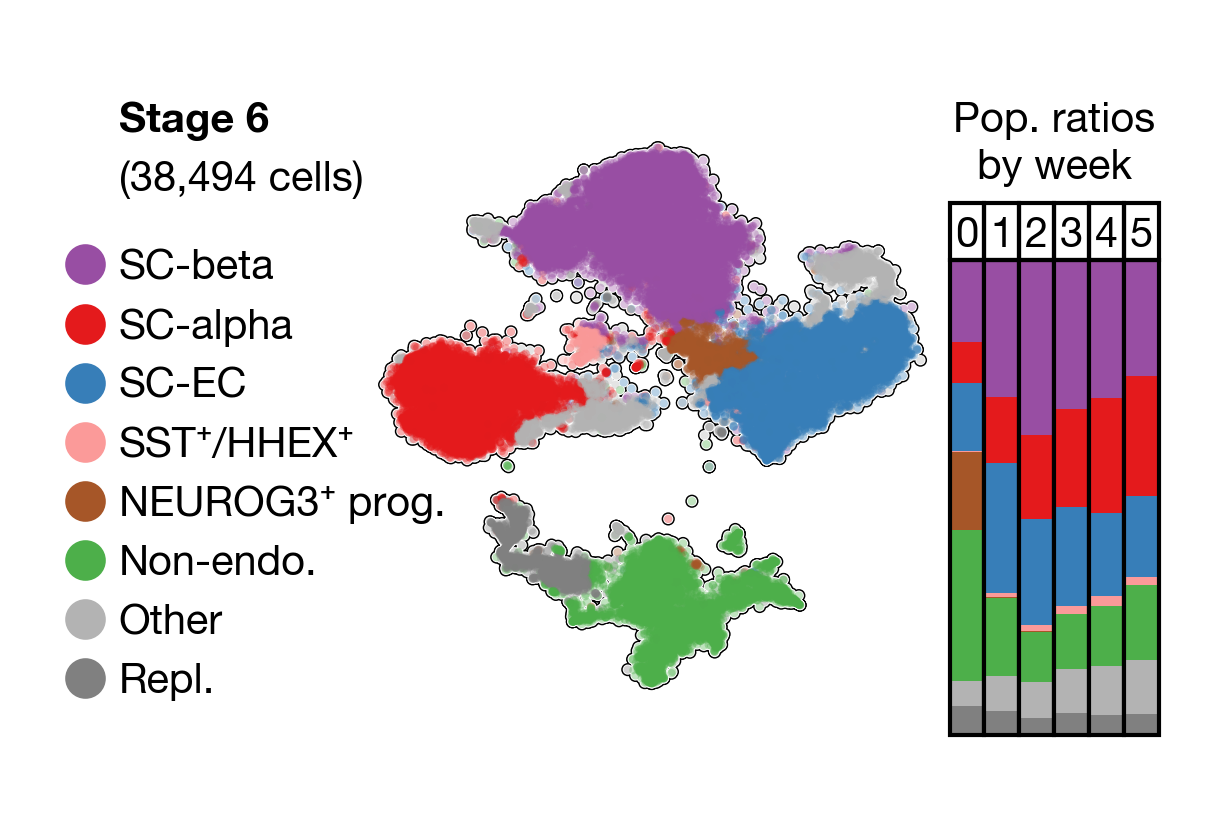

In [18]:
import matplotlib.lines as mlines
importlib.reload(fv)

tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_week = ds.ca["CellWeek"]
label_params = fv.dataset_label_params('stage6')
    

fig_h = 30/mm_per_inch
fig_w = fig_h * (3.1/2)
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(1, 2+1, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       width_ratios=[0.5, 2]+[0.6],
                       height_ratios=[1.5])

###### Draw the labels
# 
#
    
ax = fig.add_subplot(gs[0, 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])

li = 1
yl_pos = lambda lii: 1 - lii/12
xl_pos_dot = 0.13
xl_pos_text = 0.32
xl_pos_header = 0.32

ax.text(xl_pos_header, yl_pos(li), 'Stage 6', verticalalignment='center', fontsize=5,
        fontdict=dict(weight='bold'),
        clip_on=False)
li += 1

ax.text(xl_pos_header, yl_pos(li), '(%s cells)'%format(len(tsne_proj),',d'), verticalalignment='center', fontsize=5,
        clip_on=False)
li += 1.5

_present_labels = set(cell_clusters)
for lb in [lb for lb in label_order if lb in _present_labels]:
    lb_text = label_params[lb]['short_label']
    ax.scatter(xl_pos_dot, yl_pos(li)+0.005, s=fv.tsne_legend_ms, clip_on=False, c=label_params[lb]['color'].reshape(1,-1))
    for leg_label_line in lb_text.splitlines():            
        ax.text(xl_pos_text, yl_pos(li), leg_label_line, verticalalignment='center', fontsize=5, clip_on=False)
        li += 1

###### Scatter plot
# 
#

_proj, _c = fv.prepare_for_scatter(tsne_proj, cell_clusters, label_params) 

ax = fig.add_subplot(gs[0, 1], xticks=[], yticks=[],
              xscale='linear', yscale='linear',
              frameon=False,  zorder=-1)
ax.patch.set_visible(False)

s_black_, s_white, s_type = 2.5, 1.5, 1.0
ax.scatter(_proj[:, 0], _proj[:, 1], c='k', edgecolor='none', s=s_black_, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c='w', edgecolor='none', s=s_white, 
               rasterized=True)
ax.scatter(_proj[:, 0], _proj[:, 1], c=_c, edgecolor='none', s=s_type, alpha=0.35,
               rasterized=True)

# Place the tSNE further to the top, right
old_xlim = np.array(ax.get_xlim())
old_ylim = np.array(ax.get_ylim())
shift_amt = 0.2
x_span = old_xlim[1]-old_xlim[0]
y_span = old_ylim[1]-old_ylim[0]
xlim = np.array([old_xlim[0] - shift_amt*(x_span), old_xlim[1]])
ylim = np.array([old_ylim[0] - shift_amt*(y_span)*0.5, old_ylim[1] + shift_amt*(y_span)*0.5])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#
# Draw the bar under the plot
#

ax = fig.add_subplot(gs[0, 2],  ylim=[0,1],
                  xscale='linear', yscale='linear',
                  frameon=False)

ax.text(3, 1-yl_pos(1), 'Pop. ratios',
        verticalalignment='center', fontsize=5, ha='center',
        clip_on=False)
ax.text(3, 1-yl_pos(1.8), 'by week',
        verticalalignment='center', fontsize=5, ha='center',
        clip_on=False)

# 

for wk in range(6):

    
    #     ax.patch.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    
    ax.set_ylim([0,1])

    n_by_cluster = pd.Series(Counter(cell_clusters[cell_week == wk]))
    n_by_cluster = n_by_cluster/n_by_cluster.sum()
    
    cumul_frac = 0
    bar_start = 0.28
    bar_end = 0.05
    bar_len = 1 - bar_start - bar_end
    for lb in ratio_order:
        if lb in n_by_cluster:
            cl_frac = n_by_cluster[lb]
            ax.add_patch(
                patches.Rectangle(
                    (wk, bar_start + bar_len*cumul_frac), 1, bar_len*cl_frac,
                    facecolor=label_params[lb]['color'], edgecolor='none',
                    clip_on=False,
                ))
            cumul_frac += cl_frac
    
    ax.add_patch(
            patches.Rectangle(
                (wk, bar_start - 0.08), 1, 0.08,
                facecolor='none', edgecolor='k', linewidth=0.5,  clip_on=False,
            ))
    
    ax.text(wk+0.5, bar_start - 0.08/2 + 0.005, '%d'%wk,
            va='center', ha='center', fontsize=5,
            clip_on=False)
    
    ax.add_patch(
            patches.Rectangle(
                (wk, bar_start), 1, bar_len, 
                facecolor='none', edgecolor='k', linewidth=0.5,  clip_on=False,
        ))

ax.set_xlim([-0.05,6.05])
ax.set_ylim([0,1])
ax.invert_yaxis()

fig.savefig('../../figures/components/main_figure2/Stage6_summary_tSNE.pdf', dpi=600, transparent=True)


In [9]:
ax.get_ylim()

(1.0, 0.0)

## Gene by gene tSNE colorings

In [10]:
tpm_normalizer = cgm.CountsNormalizer(normalize_variance=False, mean_center=False)
tpm_normalizer.fit(ds.vals)

tpm_z_normalizer = cgm.CountsNormalizer()
tpm_z_normalizer.fit(ds.vals)

In [11]:
genes = ['INS', 'GCG', 'TPH1', 'CHGA', 'ITGA1'] + ['ISL1', 'NKX6-1', 'IAPP', 'PAX4', 'TOP2A', 'CDKN1C',]

tsne_proj = ds.ca['TSNE']
regressed_expr_values = {}

for g in genes:
    
    gi = np.where(ds.ra.Gene==g)[0]
    expr_values = tpm_normalizer.transform(ds.vals, genes=gi).T
    
    reg = fv.proj_regressor(tsne_proj, expr_values, radius=1, weights='uniform')
    pred_values = reg.predict(tsne_proj).ravel()
    
    pred_values = pred_values/np.percentile(pred_values, 98)
    pred_values = np.log10(pred_values + 0.01)
    regressed_expr_values[g] = pred_values
    


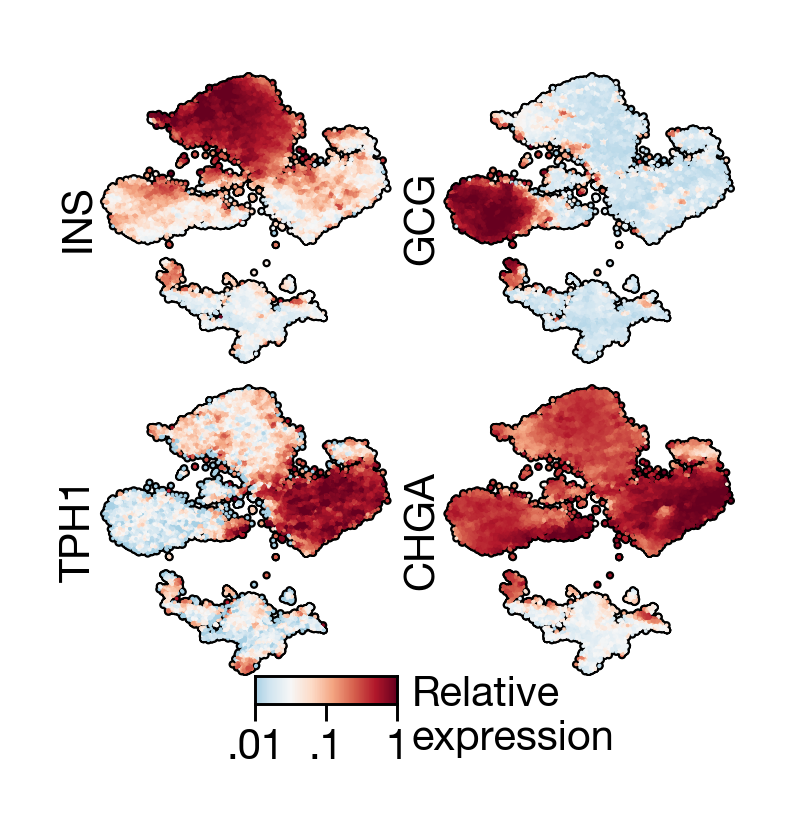

In [27]:
from sklearn.neighbors import RadiusNeighborsRegressor

importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_week = ds.ca["CellWeek"]
label_params = fv.dataset_label_params('stage6')
    
width_ratios = [0.5, 2]+[0.1]*6


fig_h = 30/mm_per_inch
fig_w = fig_h
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)


# fig = plt.figure(figsize=(2, 2), dpi=600)

# gs = gridspec.GridSpec(2, 2, fig, 0.15,0.15,0.95,0.95,
#                        hspace=1, wspace=1,
# #                        width_ratios=,
# #                        ,
#                       )


_scale = 1
gs = gridspec.GridSpec(5, 5, fig, 0,0,1,1, hspace=0, wspace=0,
                       width_ratios = [0.15, _scale, 0.10, _scale, 0.02],
                       height_ratios =  [0.02,_scale, 0.00, _scale, 0.25],
#                        width_ratios=,
#                        ,
                      )

vmin, vmax = -3, 0
for ci,(g,pi) in enumerate(zip(['INS', 'GCG', 'TPH1', 'CHGA'], [6, 8, 16, 18])):  
    ax = fig.add_subplot(gs[pi],
                  xscale='linear', yscale='linear', xticks=[], yticks=[],
                  frameon=False)
#     ax.set_title(g, pad=0)
    ax.set_ylabel(g, labelpad=-1)
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
               s=1.0, cmap='RdBu_r',
               rasterized=True)
    
    imax = ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=regressed_expr_values[g], edgecolor='none',
               s=0.2, cmap='RdBu_r', vmin=-3, vmax=0, 
               rasterized=True)
    
###### Draw the labels
# 
#

with plt.rc_context(fv.thin_legend_params):

    cvmin = -2
    cvmax = 0
    colorbar_ax_position = [0.30, 0.085, 0.20, 0.04]
    colorbar_ax = fig.add_axes(colorbar_ax_position,
                    xscale='linear', yscale='linear', yticks=[],
                    xlabel='', ylabel='', frameon=True, )

    gradient = np.linspace(cvmin, cvmax, 256)
    gradient = np.vstack((gradient, gradient))
    colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
                cmap=imax.cmap, vmin=vmin, vmax=vmax)
#     colorbar_ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)

    xticks = np.linspace(cvmin, cvmax, 5).astype(int)
    colorbar_ax.set_xticks([-2, -1, 0])
    colorbar_ax.set_xticklabels(['.01', '.1', '1'], fontsize=5);

    colorbar_ax.text(0.2, 1, 'Relative\nexpression',
                va='top', ha='left', fontsize=5,
                clip_on=False)

# colorbar_ax.set_ylabel('Rel. expr.', fontsize=5, rotation=0, ha='left')
# colorbar_ax.yaxis.set_label_position("right")


fig.savefig('../../figures/components/main_figure2/tSNE_marker_genes.pdf', dpi=600, transparent=True)
    

## Cluster expression correlation

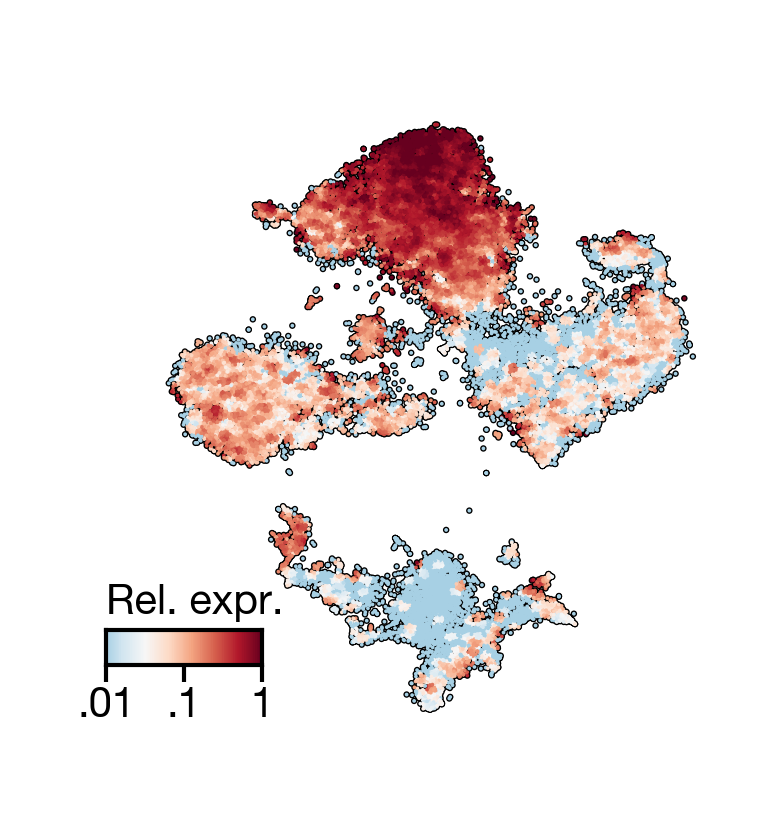

In [26]:
from sklearn.neighbors import RadiusNeighborsRegressor

importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
cell_clusters = ds.ca['Labels']
cell_week = ds.ca["CellWeek"]
label_params = fv.dataset_label_params('stage6')
    

fig_h = 30/mm_per_inch
fig_w = fig_h
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)


# gs = gridspec.GridSpec(1, 2, fig, 0.10,0.10,0.90,0.90,
#                        hspace=0.15, wspace=0.15,
#                        width_ratios= [1.5, 0.2],
# #                        ,
#                       )
g = 'ITGA1'


gs = gridspec.GridSpec(1, 3, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       width_ratios=[.05, 1.5, 0.125],
                       height_ratios=[1.5])

###### Draw the labels
# 
#
    
ax = fig.add_subplot(gs[0, 0], xticks=[], yticks=[], xlim=[0,1], ylim=[0,1],
          xscale='linear', yscale='linear',
          frameon=False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])

li = 1
yl_pos = lambda lii: 1 - lii/15
xl_pos_dot = 0.15
xl_pos_text = 0.28
xl_pos_header = 0.10

# li += 1

# ax.text(xl_pos_header, yl_pos(li), 'ITGA1/CD49a', verticalalignment='center', fontsize=5,
#         fontdict=dict(weight='bold'),
#         clip_on=False)


ci = 0
vmin, vmax = -3, 0
 
ax = fig.add_subplot(gs[0, 1],
              xscale='linear', yscale='linear', xticks=[], yticks=[],
              frameon=False)
# ax.set_title('ITGA1/CD49a', pad=0)
# ax.set_title(g, pad=0)

ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
           s=0.6, cmap='RdBu_r',
           rasterized=True)

imax = ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=regressed_expr_values[g], edgecolor='none',
           s=0.2, cmap='RdBu_r', vmin=-3, vmax=0, 
           rasterized=True)

old_xlim = np.array(ax.get_xlim())
old_ylim = np.array(ax.get_ylim())
shift_amt = 0.1
x_span = old_xlim[1]-old_xlim[0]
y_span = old_ylim[1]-old_ylim[0]
xlim = np.array([old_xlim[0] - shift_amt*(x_span), old_xlim[1]])
ylim = np.array([old_ylim[0] - shift_amt*(y_span)*0.5, old_ylim[1] + shift_amt*(y_span)*0.5])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

###### Draw the labels
# 
#

cvmin = -2
cvmax = 0
colorbar_ax_position = [0.06, 0.15, 0.22, 0.05]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(cvmin, cvmax, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)
colorbar_ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=0)

xticks = np.linspace(cvmin, cvmax, 5).astype(int)
colorbar_ax.set_xticks([-2, -1, 0])
colorbar_ax.set_xticklabels(['.01', '.1',  '1'], fontsize=5);

colorbar_ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
colorbar_ax.set_title('Rel. expr.', fontsize=5, pad=2, loc='left');


fig.savefig('../../figures/components/main_figure4/ITGA1_tSNE.pdf', dpi=600, transparent=True)
    

In [19]:
# Select 2000 high var genes

feature_selection = cgm.FeatureSelection()
feature_selection.fit(ds, ds.vals)

hv_genes = feature_selection.select_genes(n_genes=2000)
hv_genes = ds.ra.Gene[hv_genes]

pb_z = pb_tpm['stage6.time_labels'][hv_genes]
pb_z -= pb_z.mean()
pb_z /= pb_z.std(ddof=0)

cl_corr = pb_z.T.corr()

cl_order = ['0__neurog3']
for cl in ['scbeta', 'ec', 'ph', 'exo', 'other']:
    for wk in range(6):
        cl_order.append(f'{wk}__{cl}')

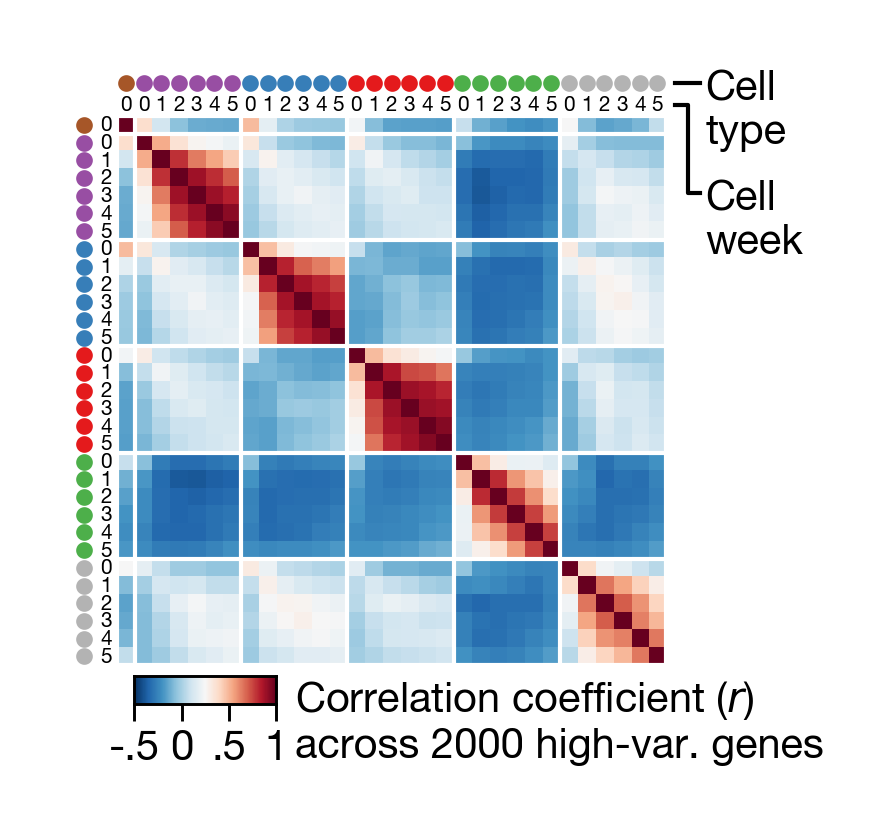

In [27]:
cwk_corr = cl_corr.loc[:, cl_order].loc[cl_order, :]


width_ratios = [0.08, 0.13, 0.90-0.21]
height_ratios = [1.5]
label_params = fv.dataset_label_params('stage6')

fig_h = 30/mm_per_inch
fig_w = fig_h * 1.10
    
fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

wr = np.array([0.01, 0.10, 1, 0.18])
xwr = list(wr/sum(wr))
xwr[-1] += 0.10

gs = gridspec.GridSpec(4, 4, fig, 0, 0, 1, 1,
                       
                       width_ratios=xwr,
                       height_ratios=wr,
                       hspace=0, wspace=0)

ax = fig.add_subplot(gs[2,2], xscale='linear', yscale='linear', 
        xlabel='', ylabel='',
        title='', frameon=False)

grp_sep_locations = np.array([-1] + list(range(0, 31, 6)))
sample_labels = cl_order

vmin = -0.5
vmax = 1
im = ax.imshow(cwk_corr, interpolation='nearest', cmap='RdBu_r', aspect='auto', origin='upper',
              vmax=vmax, vmin=vmin)
for grp_sep in grp_sep_locations:
    ax.axvline(grp_sep+0.5, color='w', linewidth=0.5, clip_on=False)
    ax.axhline(grp_sep+0.5, color='w', linewidth=0.5, clip_on=False)

ax.set_xticks([])
ax.set_yticks([])





ax_side = fig.add_subplot(gs[2,1], xscale='linear', yscale='linear', xticks=[], yticks=[],
        xlabel='', ylabel='', frameon=False, zorder=-5)

ax_top = fig.add_subplot(gs[1,2], xscale='linear', yscale='linear', xticks=[], yticks=[],
        xlabel='', ylabel='', frameon=False, zorder=-5)


ax_side.set_xlim([-1, 2-0.5])
ax_side.set_ylim([len(sample_labels)-0.5, -0.5, ])
ax_side.set_yticks([])

ax_top.set_ylim([2-0.5, -1])
ax_top.set_xlim([-0.5, len(sample_labels)-0.5])
ax_top.set_xticks([])


# xtick_labels = ["Cell\ntype\n", "Week",]

# ax.set_xticks(range(len(xtick_labels)))
# ax.set_xticklabels(xtick_labels, fontsize=5, rotation=90)
# ax.xaxis.tick_top()

for i,wk_cl in enumerate(sample_labels):
    wk, cl = wk_cl.split('__')
    ax_side.scatter([0], [i],  c=label_params[cl]['color'].reshape(1, -1), s=1) 
    ax_top.scatter([i], [0],  c=label_params[cl]['color'].reshape(1, -1), s=1) 
    
    ax_side.text(1, i, wk, verticalalignment='center', horizontalalignment='center',
            fontsize=2.5, clip_on=False)
    ax_top.text(i, 1, wk, verticalalignment='center', horizontalalignment='center',
            fontsize=2.5, clip_on=False)

    
ax_top.text(len(sample_labels)+1.7, -0.62, 'Cell\ntype',
            va='top', ha='left',
            fontsize=5, clip_on=False)

line = mlines.Line2D([len(sample_labels), len(sample_labels)+1.4],
                     [0, 0],
                    
                    linewidth=0.5, color='k',
                    clip_on=False)
ax_top.add_artist(line)

ax_top.text(len(sample_labels)+1.7, 5-0.62, 'Cell\nweek',
            va='top', ha='left',
            fontsize=5, clip_on=False)

line = mlines.Line2D([len(sample_labels), len(sample_labels)+0.7, len(sample_labels)+0.7, len(sample_labels)+1.4],
                     [1, 1, 5,  5],
                    
                    linewidth=0.5, color='k',
                    clip_on=False)
ax_top.add_artist(line)

# Colorbar

with plt.rc_context(fv.thin_legend_params):
    cvmin = -0.5
    cvmax = 1
    colorbar_ax_position = [0.10, 0.085, 0.20/1.10, 0.04]
    colorbar_ax = fig.add_axes(colorbar_ax_position,
                    xscale='linear', yscale='linear', yticks=[],
                    xlabel='', ylabel='', frameon=True, )

    gradient = np.linspace(cvmin, cvmax, 256)
    gradient = np.vstack((gradient, gradient))
    colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
                cmap=im.cmap, vmin=vmin, vmax=vmax)

    xticks = np.linspace(cvmin, cvmax, 5).astype(int)
    colorbar_ax.set_xticks([-0.5, 0, 0.5, 1])
    colorbar_ax.set_xticklabels(['-.5', '0', '.5', '1'], fontsize=5);

    colorbar_ax.text(1.2, 1.0, r'Correlation coefficient ($\it{r}$)''\nacross 2000 high-var. genes',
                va='top', ha='left', fontsize=5,
                clip_on=False)
    
fig.savefig('../../figures/components/main_figure2/CorrOverTime.pdf')

## Pseudotime -- on tSNE

In [11]:
scb_cells = np.where(np.isin(ds.ca.CellID, list(scb_ds.ca.CellID)))[0]

scb_cells_index = ds.ca.CellID[scb_cells]
pdt = pd.Series(scb_ds.ca.PseudotimeRank, scb_ds.ca.CellID)[scb_cells_index].values
cell_week = ds.ca.CellWeek[scb_cells]

In [12]:
scb_tsne_proj = tsne_proj[scb_cells]


NameError: name 'tsne_proj' is not defined

2019-02-14 12:47:59,236 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


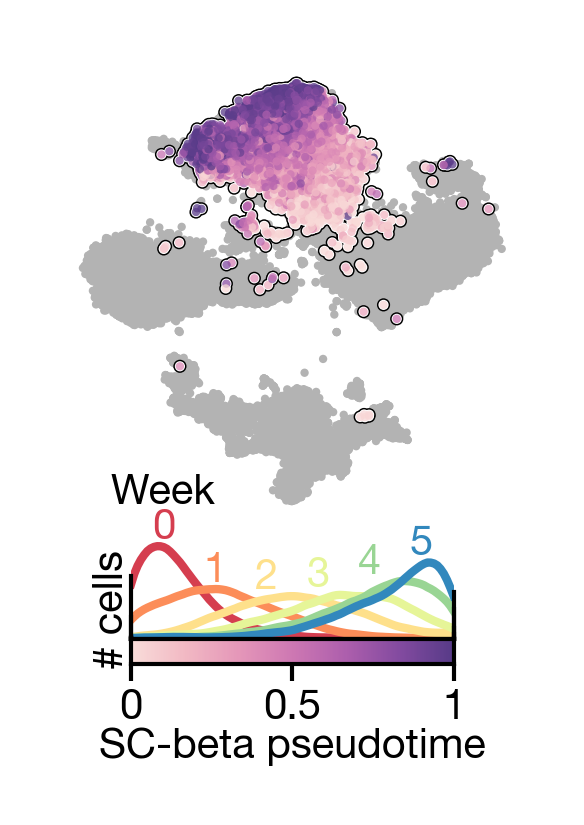

In [22]:


importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
label_params = fv.dataset_label_params('stage6')
    

fig_h = 30/mm_per_inch
fig_w = fig_h * (1.3/2)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(5, 3, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       width_ratios=[0.30, 1.4, 0.30],
                       height_ratios=[1.3] + list(np.array([0.00, 0.47, 0.10, 0.43])*0.7),
                      )



ax = fig.add_subplot(gs[0, :],
              xscale='linear', yscale='linear', xticks=[], yticks=[],
              frameon=False)

_all_proj = tsne_proj
_sub_proj = tsne_proj[scb_cells]
s_grey, s_black, s_white, s_type = 1.0, 2.5, 1.5, 1.0


ax.scatter(_all_proj[:, 0], _all_proj[:, 1], c=core_colors.light_grey, edgecolor='none', s=s_grey, 
               rasterized=True)
ax.scatter(_sub_proj[:, 0], _sub_proj[:, 1], c='k', edgecolor='none', s=s_black, 
               rasterized=True)
ax.scatter(_sub_proj[:, 0], _sub_proj[:, 1], c='w', edgecolor='none', s=s_white, 
               rasterized=True)
im = ax.scatter(_sub_proj[:, 0], _sub_proj[:, 1], c=pdt, edgecolor='none', s=s_type, alpha=0.75,
               cmap=palettable.cartocolors.sequential.PurpOr_7.get_mpl_colormap(),
               vmin=0, vmax=1,
               rasterized=True)



# im = ax.scatter(scb_tsne_proj[:, 0], scb_tsne_proj[:, 1], c=pdt, edgecolor='none',
#            s=0.8,
#            cmap=palettable.cartocolors.sequential.PurpOr_7.get_mpl_colormap(),
#            vmin=0, vmax=1,
#            rasterized=True)


ax = fig.add_subplot(gs[2,1],
              xscale='linear', yscale='linear', yticks=[],xticks=[],
              frameon=True)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('# cells', labelpad=0, y=0.25)

ymin, ymax = ax.get_ylim()

pdt_bins = np.linspace(0,1,100)
for wk in range(6):
    wk_dpt = pdt[cell_week==wk]
    wk_color = fv.to_array_col(palettable.colorbrewer.diverging.Spectral_6.colors[wk])
    kde = KernelDensity(kernel='exponential', bandwidth=0.05).fit(wk_dpt.reshape(-1,1))
    vals = np.exp(kde.score_samples(pdt_bins.reshape(-1,1)))
    vals /= sp.integrate.simps(vals, pdt_bins)
    
    x_show = [0]+list(pdt_bins)+[1]
    y_show = [0]+list(vals)+[0]
    
    x_show = list(pdt_bins)
    y_show = list(vals) 
    ax.plot(x_show, y_show,
            color=wk_color,
            linewidth=1.0,
            clip_on=True,
           )
    ax.plot([0, 0], [0, y_show[0]*1.15], color='k', linewidth=0.5, clip_on=False, zorder=10)
    ax.plot([1, 1], [0, y_show[-1]*1.08], color='k', linewidth=0.5, clip_on=False, zorder=10)
    max_i = vals.argmax()
    
    if wk==0:
        ax.text(0.1, vals[max_i]*1.38, 'Week', ha='center', va='bottom',
                color='k', fontsize=5)
    ax.text(np.linspace(0.1, 0.9, 6)[wk], vals[max_i], f'{wk}', ha='center', va='bottom',
            color=wk_color, fontsize=5)
    
    
ax.set_xlim((0,1))
ax.set_ylim([0, ax.get_ylim()[1]*1.2])


ax = fig.add_subplot(gs[3,1],
              xscale='linear', yscale='linear',  yticks=[],
              frameon=True)
    
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', extent=(0,1,0,1), 
            cmap=im.cmap, vmin=0, vmax=1, clip_on=False)


ax.set_xticks([0, 0.5, 1.0])
ax.tick_params(axis='both', which='major', pad=1, width=0.5, zorder=-10, length=2)
ax.set_xticklabels(['0', '0.5', '1'], fontsize=5);
ax.set_xlabel('SC-beta pseudotime', labelpad=0);

fig.savefig('../../figures/components/main_figure2/SCbeta_tsne_proj.pdf', dpi=600, transparent=True)
    

## Pseudotime -- model fitting

In [13]:
pdt_ds = scb_ds

In [14]:
from scbeta_scrnaseq import pseudotime

In [15]:
import importlib

In [16]:
# importlib.reload(pseudotime)
pseudotime.annotate_vgam_ds(scb_ds)


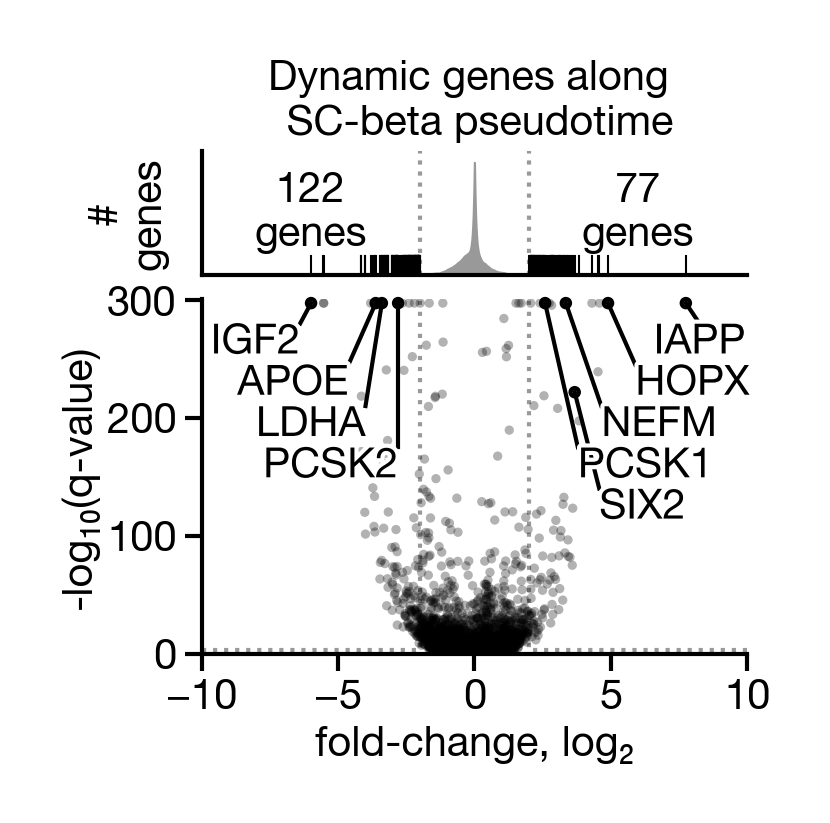

In [15]:
from matplotlib import lines as mlines


fig_h = 30/mm_per_inch
fig_w =fig_h

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

_reg = np.where(pdt_ds.ra['_Regressed'])[0]

gs = gridspec.GridSpec(2, 1, fig, 0.20, 0.16, 0.97,0.87,
                       hspace=0.1, wspace=0,
#                        width_ratios=[0.5, 2]+[0.1]*6,
                       height_ratios=[0.7,2],
                      )

# Draw the labels.
ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True,
#             xticks=[], yticks=[],
                    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x = pd.Series(pdt_ds.ra['Pred__pseudotime__log2fc__start_end'][_reg], index=scb_ds.ra.Gene[_reg])
y = pd.Series(-np.log10(pdt_ds.ra['LRT_Pseudotime_qval'][_reg]), index=scb_ds.ra.Gene[_reg])
ax.scatter(x, y,
           c='k', marker='.', edgecolor='none', s=5, alpha=0.3, rasterized=True, clip_on=True)

gene_label_fontsize = 6




up_genes = [
    ('IGF2', (+0.6,+20.0), 'right', 'top'),
    ('APOE', (0.0,0.0), 'right', 'top'),
    ('LDHA', (+0.4,-25.0), 'right', 'top'),
    ('PCSK2', (+1.,-70.0), 'right', 'top'),
]

down_genes = [
    ('IAPP', (0.5,-0.), 'center', 'top'),
    ('HOPX', (0., +20.), 'left', 'top'),
    ('NEFM', (0.3,-5.), 'left', 'top'),
    ('PCSK1', (0.2,-35.), 'left', 'top'),
    ('SIX2', (-0.1,0.), 'left', 'top'),
]

import matplotlib.patheffects as PathEffects
for col, label_genes in [('k', up_genes), ('k', down_genes)]:
    
    ax.scatter(x[[g for g,_,_,_ in label_genes]], y[[g for g,_,_,_ in label_genes]], c='none',
           s=1, edgecolor=col, clip_on=False,
           alpha=1.0, linewidths = 0.5)
    

    for gi,(g,g_offset,ha,va) in enumerate(label_genes):

        x_offset, y_offset = np.array(g_offset)
        if ha == 'right':
            x_offset += -1
        if ha == 'left':
            x_offset += 1
        if va == 'top':
            y_offset += -25
        if va == 'bottom':
            y_offset += 25
            
        gtx = x[g] + (x_offset)
        gty = 280 - gi*35

        txt = ax.text(gtx, gty, g,
                      fontsize=5, color=col,
                      va=va, ha=ha)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

        ax.plot([x[g], gtx], [y[g], gty], linewidth=0.5, color=col, clip_on=False)
        
xlim = [-10, 10]
ylim = [0, 301]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

fc_thr = 2
fdr_thr = 3
thr_style = dict(color=core_colors.grey,linestyle='dotted', linewidth=0.5,zorder=-2)
line = mlines.Line2D([xlim[0], -fc_thr, -fc_thr], [fdr_thr, fdr_thr, ylim[1]], 
                    **thr_style
                    )
line.set_clip_on(False)
ax.add_line(line)

line = mlines.Line2D([xlim[1], fc_thr, fc_thr], [fdr_thr, fdr_thr, ylim[1]], 
                     **thr_style
                    )
line.set_clip_on(False)
ax.add_line(line)



# ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
ax.set_ylabel('-log₁₀(q-value)', labelpad=1)
ax.set_xlabel('fold-change, log₂', labelpad=1)

ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          ylabel='#\ngenes',
          frameon=True,
            xticks=[], yticks=[])
ax.set_title('Dynamic genes along \n SC-beta pseudotime', pad=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fc_bins = np.linspace(-10, 10, 1000)

kde = KernelDensity(kernel='exponential', bandwidth=0.05).fit(x.values.reshape(-1,1))
vals = np.exp(kde.score_samples(fc_bins.reshape(-1,1)))
vals /= sp.integrate.simps(vals, fc_bins)
vals *= len(y)

ax.fill_between([-10]+list(fc_bins)+[10], [0]+list(vals)+[0], 
        color=core_colors.grey,
        linewidth=0.2,
        clip_on=True,
       )

new_ylim = ax.get_ylim()[1]*1.05
ax.set_ylim([0, new_ylim])

ax.axvline(-fc_thr, **thr_style)
ax.axvline(fc_thr, **thr_style)
ax.set_xlim(xlim)

down_de = (y > fdr_thr) & (x < -fc_thr)
up_de = (y > fdr_thr) & (x > fc_thr)

for g in down_de[down_de | up_de].index:
    ax.axvline(x[g], 0, 0.15
               , linewidth=0.25, color='k')

ax.text((xlim[0]-fc_thr)/2, new_ylim/2, '%d\ngenes'%sum(down_de),
        fontsize=5, va='center', ha='center')

ax.text((xlim[1]+fc_thr)/2, new_ylim/2, '%d\ngenes'%sum(up_de),
        fontsize=5, va='center', ha='center')



fig.savefig('../../figures/components/main_figure2/SCbeta_pseudotime_volcano.pdf', transparent=True)

In [17]:
scb_norm = cgm.CountsNormalizer(normalize_variance=False, mean_center=False)
scb_norm.fit(scb_ds.vals)


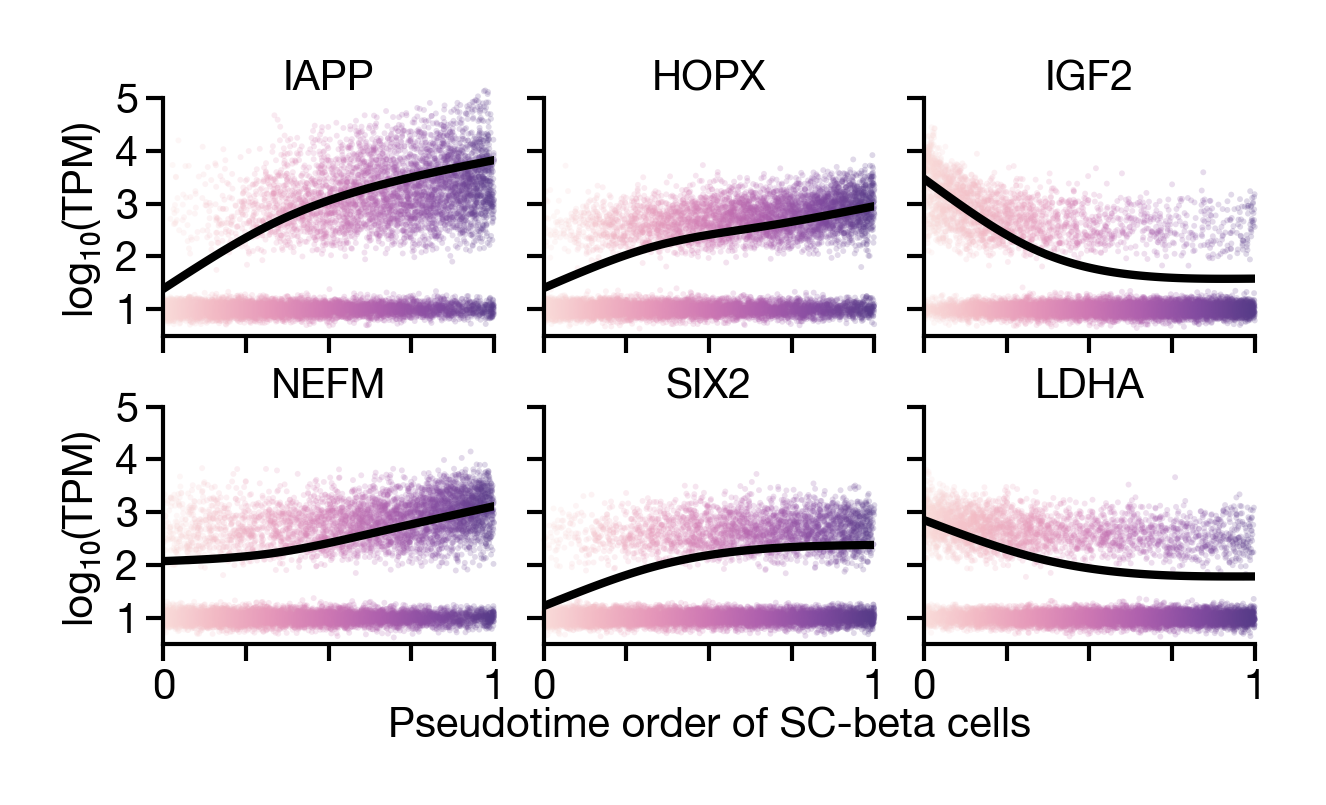

In [18]:

fig_h = 30/mm_per_inch
fig_w = fig_h * (3.5/2)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=600)

gs = gridspec.GridSpec(2, 3, fig, 0.11, 0.16, 0.99,0.93,
                       hspace=0.3, wspace=0.15,
#                        width_ratios=[0.5, 2]+[0.1]*6,
#                        height_ratios=[1,3],
                      )

# Draw the labels.

for ci, g in enumerate(['IAPP', 'HOPX', 'IGF2', 
                        'NEFM', 'SIX2', 'LDHA']):
    ax = fig.add_subplot(gs[ci],
              xscale='linear', yscale='linear',
              frameon=True,
                xticks=[],
                        )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(g, pad=1)
    
    gi = np.where(scb_ds.ra.Gene == g)[0]
    if len(gi) == 0:
        continue
        
    cell_pdt = scb_ds.ca.PseudotimeRank
    expr_pv = 0.1
    cell_expr = np.log10(scb_norm.transform(scb_ds.vals, genes=gi) + expr_pv)
    
    np.random.seed(ci)
    cell_expr +=np.random.randn(*cell_expr.shape)/10
    
    fit_expr = np.log10(pdt_ds.ra['Pred__pseudotime__tpm'][gi].ravel())
    fit_domain = np.linspace(0, 1, len(fit_expr))

    ax.scatter(cell_pdt, cell_expr, c=cell_pdt,
               marker='.', s=2, edgecolor='none', alpha=0.2, 
               cmap=palettable.cartocolors.sequential.PurpOr_7.get_mpl_colormap(),
               vmin=0, vmax=1,
               clip_on=False,
               rasterized=True)

    ax.plot(fit_domain, fit_expr, linewidth=1, c='k', clip_on=True,)
    ax.set_xlim((0,1))
#     ax.set_ylim((-0.25,5))
    
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels([])
    ax.set_yticks([-1, 0,1,2,3])
#     ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
    
    if ax.is_first_col():
        ax.set_yticklabels([1, 2, 3, 4, 5])
        ax.set_ylabel(r'log₁₀(TPM)', labelpad=2)
    else:
        ax.set_yticklabels([])
        
    if ax.is_last_row():
        ax.set_xticklabels([0, '', '', '', '1'])
        
    ax.set_ylim([-1.5,3])
    if ci==4:
        ax.set_xlabel('Pseudotime order of SC-beta cells', labelpad=0)
        
#     ax.text(0.5, 4.8, g, ha='center', va='center', fontsize=rcParams['axes.labelsize'])
    

fig.savefig('../../figures/components/main_figure2/SCbeta_single_genes.pdf')

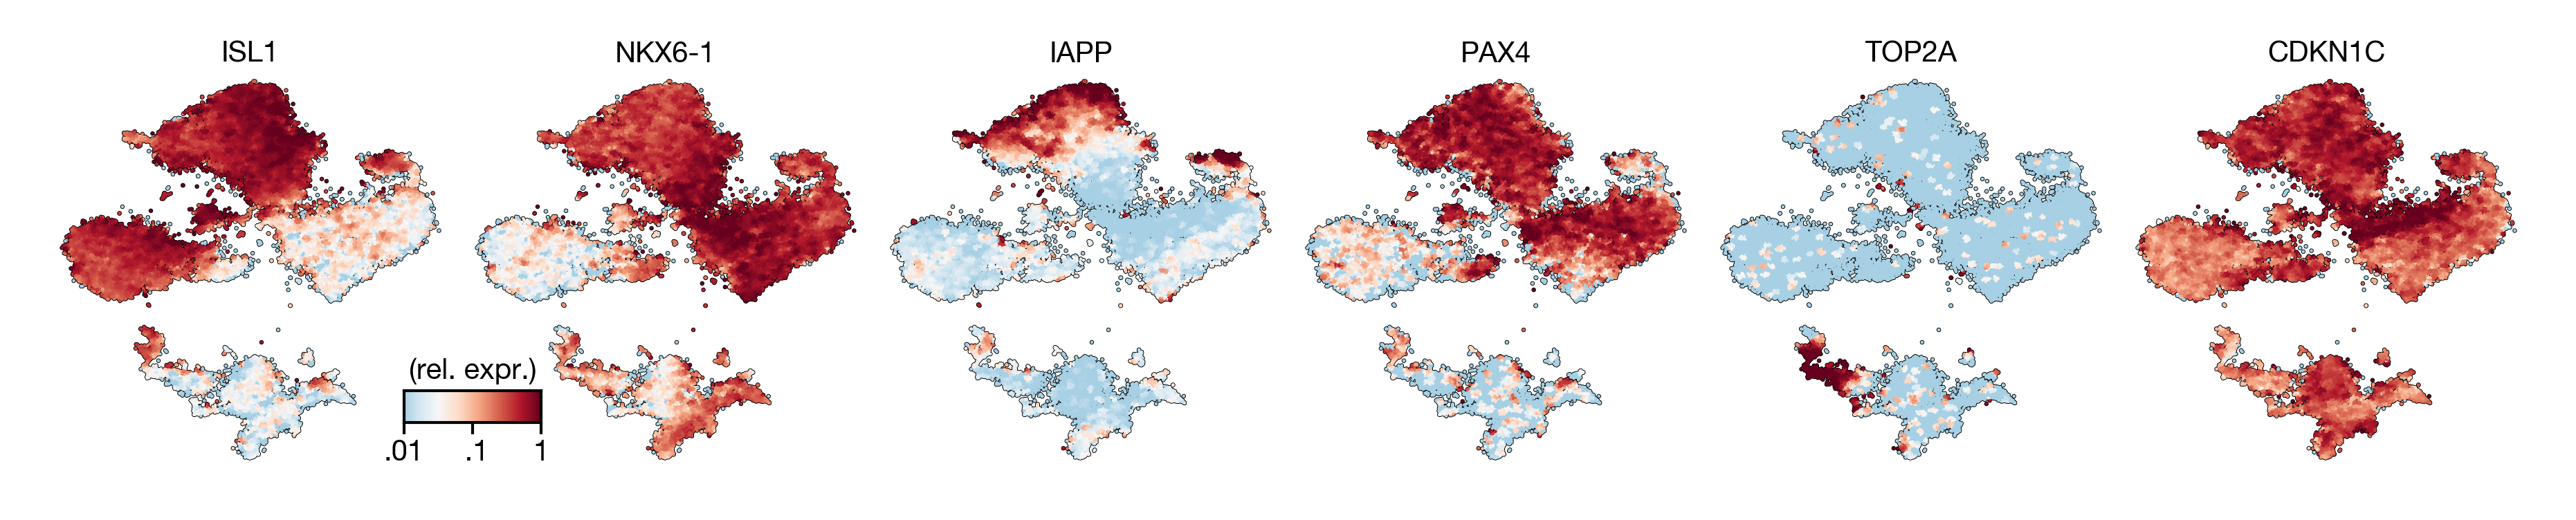

In [37]:
# importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
    
vmin, vmax = -3, 0

fig = plt.figure(figsize=(6, 1.10), dpi=600)

gs = gridspec.GridSpec(2, 6, fig, 0,0,1,1, hspace=0, wspace=0,
                       height_ratios=[0.1, 1])

sm_display_s = 0.3
sm_outline_s = 0.6

###### Draw the labels
# 
#

for ci,g in enumerate(['ISL1', 'NKX6-1', 'IAPP', 'PAX4', 'TOP2A', 'CDKN1C',]):
   

    ax = fig.add_subplot(gs[1, ci], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.set_title(g, pad=0)
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
               s=sm_outline_s, cmap='RdBu_r',
               rasterized=True)

    imax = ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=regressed_expr_values[g], edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    ax.patch.set_visible(False)


##### Draw the labels
# 
#

cvmin = -2
cvmax = 0
colorbar_ax_position = [0.145, 0.12, 0.055, 0.07]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(cvmin, cvmax, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(cvmin,cvmax,0,1), 
            cmap=imax.cmap, vmin=vmin, vmax=vmax)
# colorbar_ax.tick_params(axis='both', which='major', pad=2, width=0.5, zorder=-10, length=2)

xticks = np.linspace(cvmin, cvmax, 5).astype(int)
colorbar_ax.set_xticks([-2, -1, 0])
colorbar_ax.set_xticklabels(['.01',' .1', '1'], fontsize=5);

colorbar_ax.set_title('(rel. expr.)', fontsize=5, pad=2);


fig.savefig('../../figures/components/extended_figure3/ExtendedFigure3B.pdf', dpi=600)


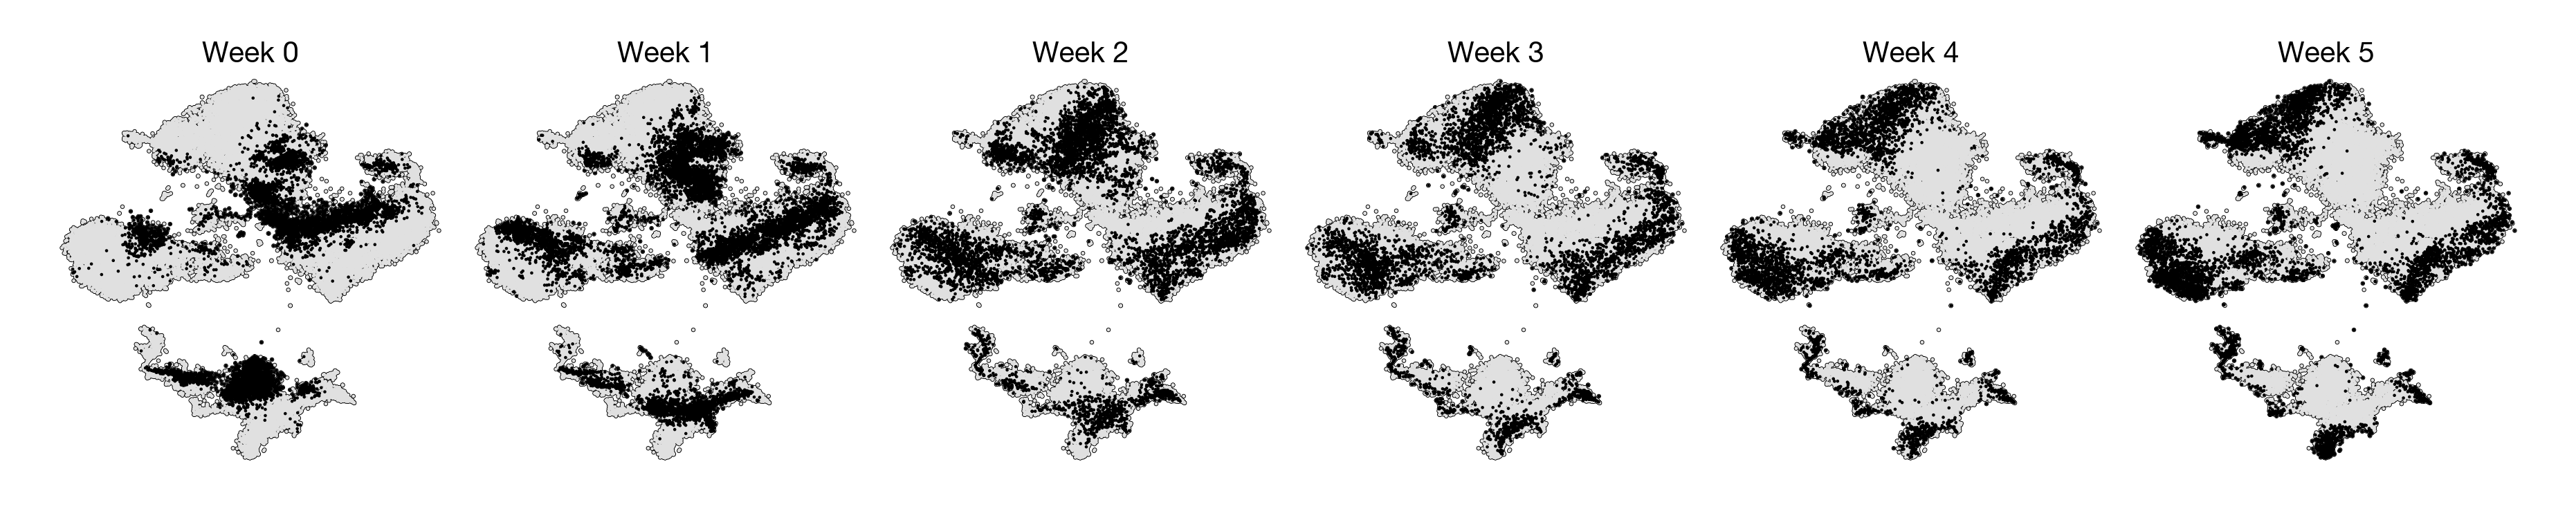

In [38]:
# importlib.reload(fv)# _ds = tds[s]
tsne_proj = ds.ca['TSNE']
    
fig = plt.figure(figsize=(6, 1.10), dpi=600)

gs = gridspec.GridSpec(2, 6, fig, 0,0,1,1, hspace=0, wspace=0,
                       height_ratios=[0.1, 1])

sm_display_s = 0.3
sm_outline_s = 0.6

###### Draw the labels
# 
#

for wk in range(6):
    ci = wk
    ax = fig.add_subplot(gs[1, ci], xticks=[], yticks=[],
                  xscale='linear', yscale='linear',
                  frameon=False,  zorder=-1)
    ax.set_title(f'Week {wk}', pad=0)
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='k', edgecolor='none',
               s=sm_outline_s, cmap='RdBu_r',
               rasterized=True)
    
    ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c='#e0e0e0', edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    
    cell_day_filter = ds.ca.CellWeek==wk
    
    imax = ax.scatter(tsne_proj[cell_day_filter, 0], tsne_proj[cell_day_filter, 1], c='k', edgecolor='none',
               s=sm_display_s, cmap='RdBu_r', vmin=vmin, vmax=vmax,
               rasterized=True)
    ax.patch.set_visible(False)


##### Draw the labels
# 
#


fig.savefig('../../figures/components/extended_figure3/ExtendedFigure3A.pdf', dpi=600)
